# 3rd Level Model Structure: Everything (Linking Stages)

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from pyomo import environ as pe
from modules.global_set import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF

model = pe.ConcreteModel()

# Global Set

In [3]:
model.TRAY = pe.RangeSet(1,1)

# Construct Reactive Stages

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].T_F
| reactive[1].P
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].T
| reactive[1].H_F
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].r_total_comp
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_block.r_WGS
| reactive[1].kinetics_bloc

# Construct a single condenser

In [5]:
model.condenser = pe.Block(rule=condenser_stage_rule)

| Importing Condenser Stage......
| Adding the following local variable:
------------------------------------
| condenser.T
| condenser.T_F
| condenser.P
| condenser.Q_main
| condenser.x_
| condenser.y_
| condenser.x
| condenser.y
| condenser.z
| condenser.L
| condenser.W
| condenser.V
| condenser.F
| condenser.H_L_
| condenser.H_V_
| condenser.H_L
| condenser.H_V
| condenser.H_F
| condenser.f_V
| condenser.f_L
------------------------------------

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.energy_block.dH_F
| condenser.energy_block.dH_V
| condenser.energy_block.dH_L
| condenser.energy_block.dH_vap
--------------------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| condenser.VLE_block.n_ave
| condenser.VLE_block.n_ave_cal
| condenser.VLE_block.Hen
| condenser.VLE_block.Hen0
| condenser.VLE_blo

# Linking Stage Variables

### Vapor Between Reactive Stages

In [6]:
def V_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

def Vy_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

def Vh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

### Liquid Between Reactive Stages

In [7]:
def L_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

def Lx_between_rule(model,j,i):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

def Lh_between_rule(model,j):
    if j == model.TRAY.last(): return pe.Constraint.Skip
    return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

### Condenser

In [8]:
def V_condenser_rule(model):
    return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

def Vy_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

def Vh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

In [9]:
def L_condenser_rule(model):
    return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

def Lx_condenser_rule(model,i):
    return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

def Lh_condenser_rule(model):
    return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

# Fixing Redundent Stream Variables

In [10]:
# condenser
model.condenser.VLE_block.n_ave.fix(58)

model.condenser.F.fix(0)
model.condenser.T_F.fix(300+273.15)
model.condenser.z.fix(0)

model.condenser.V['P'].fix(0)
model.condenser.L['in'].fix(0)
for i in m.COMP_TOTAL: model.condenser.x_['in',i].fix(0)
model.condenser.H_L_['in'].fix(0)

In [11]:
# 'reboiler' fixing last stage V_in

model.reactive[model.TRAY.last()].V['in'].fix(0)
for i in m.COMP_TOTAL: model.reactive[model.TRAY.last()].y_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)

In [12]:
check_DOF(pe,model)

Active Equality Constraints:	 1980
Active Inequality Constraints:	 0
Active Variables:		 2163
Fixed Variables:		 169
DOF:				 14


# Load Operating Parameters

In [13]:
# condenser
model.condenser.P.fix(19)
# model.condenser.T.fix(30+273.15)
model.condenser.T.fix(30+273.15)
model.condenser.L['out'].setub(12)
model.condenser.L['P'].fix(0)

# reactive stage
for j in model.reactive:
    model.reactive[j].cat.fix(1500)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(58)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(0.3333)
    model.reactive[j].z['H2'].fix(0.6666)
    model.reactive[j].z['C30H62'].fix(0.0001)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    # model.reactive[j].Q_main.fix(0)
    # model.reactive[j].T.setub(240+273.15)

In [14]:
check_DOF(pe,model)

Active Equality Constraints:	 1980
Active Inequality Constraints:	 0
Active Variables:		 2163
Fixed Variables:		 182
DOF:				 1


In [15]:
model.obj = pe.Objective(expr = model.reactive[1].T ,sense=pe.maximize)

In [16]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['constr_viol_tol'] = 1e-7
# opt.options['acceptable_constr_viol_tol'] = 1e-7
opt.options['max_iter'] = 7000
# opt.options['dual_inf_tol'] = '+inf'
# opt.options['acceptable_dual_inf_tol'] = '+inf'

In [17]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [18]:
results = opt.solve(model,tee=True)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     6375
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.....

  84r-5.1235047e+02 5.34e-01 9.99e+02  -0.3 0.00e+00    -  0.00e+00 2.80e-07R  4
  85r-5.1235302e+02 5.33e-01 1.03e+03  -0.3 2.86e+02    -  2.49e-03 1.94e-04f  1
  86r-5.1240988e+02 5.04e-01 1.04e+03  -0.3 2.89e+02    -  5.17e-03 4.39e-03f  1
  87r-5.1252600e+02 4.64e-01 1.03e+03  -0.3 2.97e+02    -  9.93e-03 9.39e-03f  1
  88 -5.1252790e+02 4.64e-01 2.82e+02  -1.0 3.12e+02    -  1.80e-04 2.63e-04h  1
  89 -5.1270048e+02 4.63e-01 3.01e+03  -1.0 8.20e+02    -  1.15e-03 1.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -5.1270251e+02 4.63e-01 7.90e+03  -1.0 6.06e+02    -  3.25e-03 3.20e-05h  1
  91 -5.1270272e+02 4.63e-01 4.17e+05  -1.0 3.54e+02    -  1.54e-02 1.18e-04h  1
  92 -5.1270286e+02 4.63e-01 1.01e+08  -1.0 3.56e+02    -  2.45e-02 8.98e-05h  1
  93r-5.1270286e+02 4.63e-01 1.00e+03  -0.3 0.00e+00    -  0.00e+00 4.50e-07R  2
  94r-5.1270454e+02 4.62e-01 1.11e+03  -0.3 3.06e+02    -  9.89e-03 1.51e-04f  1
  95r-5.1279496e+02 4.48e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -5.1952953e+02 6.80e-02 4.62e+05  -1.0 5.20e+02    -  2.18e-02 1.59e-03h  7
 181 -5.1953296e+02 6.79e-02 5.79e+05  -1.0 5.12e+02    -  9.46e-02 8.58e-04h  8
 182 -5.1953639e+02 6.79e-02 6.17e+05  -1.0 5.09e+02    -  3.11e-02 8.84e-04h  8
 183 -5.1954295e+02 6.78e-02 1.18e+06  -1.0 5.05e+02    -  4.41e-01 1.75e-03h  7
 184 -5.1954904e+02 6.77e-02 1.22e+06  -1.0 4.97e+02    -  2.80e-02 1.72e-03h  7
 185 -5.1955473e+02 6.75e-02 1.34e+06  -1.0 4.90e+02    -  9.65e-02 1.68e-03h  7
 186 -5.1956011e+02 6.74e-02 1.40e+06  -1.0 4.84e+02    -  4.71e-02 1.66e-03h  7
 187 -5.1988819e+02 1.32e+00 7.22e+07  -1.0 4.77e+02    -  1.12e-01 1.05e-01w  1
 188 -5.1999159e+02 1.34e+00 7.00e+07  -1.0 2.01e+02    -  2.44e-01 4.02e-02w  1
 189 -5.2050010e+02 3.53e+00 7.62e+07  -1.0 1.60e+02    -  1.99e-01 2.74e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -5.1956524e+02 6.73e-02

 274 -5.2014118e+02 5.33e-02 1.86e+14  -1.0 1.35e+02    -  2.15e-01 6.11e-03h  7
 275 -5.2015531e+02 5.29e-02 2.41e+14  -1.0 1.31e+02    -  1.00e+00 6.18e-03h  7
 276 -5.2016874e+02 5.26e-02 2.41e+14  -1.0 1.28e+02    -  2.24e-01 6.23e-03h  7
 277 -5.2020040e+02 5.21e-02 2.41e+14  -1.0 1.23e+02    -  4.49e-01 9.90e-03h  6
 278 -5.2098249e+02 3.92e+00 1.42e+14  -1.0 1.20e+02    -  4.02e-01 4.07e-01w  1
 279 -5.2098249e+02 3.92e+00 1.28e+14  -1.0 7.28e-03  15.4 9.97e-02 4.43e-03w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -5.2098249e+02 3.92e+00 8.68e+13  -1.0 3.50e-04  15.8 3.23e-01 3.72e-04w  1
 281 -5.2022484e+02 5.34e-02 2.42e+14  -1.0 4.34e-03  15.4 4.02e-01 1.27e-02h  5
 282 -5.2025532e+02 5.65e-02 2.42e+14  -1.0 1.13e+02    -  6.18e-01 1.30e-02h  6
 283 -5.2028204e+02 5.93e-02 2.42e+14  -1.0 1.08e+02    -  3.19e-01 1.32e-02h  6
 284 -5.2031067e+02 6.21e-02 2.43e+14  -1.0 1.03e+02    -  8.73e-01 1.35e-02h  6
 285 -5.2033617e+02 6.47e-02

 369 -5.1420591e+02 3.41e-02 2.64e+08  -1.0 1.45e+01    -  1.00e+00 1.49e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -5.0719384e+02 2.56e+00 7.22e+07  -1.0 1.48e+01    -  1.00e+00 9.53e-01w  1
 371 -5.0731732e+02 2.52e+00 7.17e+07  -1.0 8.80e+01    -  2.09e-01 3.82e-03w  1
 372 -5.0731839e+02 2.52e+00 7.17e+07  -1.0 1.51e+04    -  9.84e-04 7.17e-05w  1
 373 -5.1409635e+02 3.37e-02 2.70e+08  -1.0 2.36e+04    -  1.00e+00 1.49e-02h  6
 374 -5.1398498e+02 3.32e-02 2.75e+08  -1.0 1.50e+01    -  1.00e+00 1.49e-02h  7
 375 -5.1387170e+02 3.28e-02 2.77e+08  -1.0 1.53e+01    -  1.00e+00 1.48e-02h  7
 376 -5.1375644e+02 3.23e-02 2.79e+08  -1.0 1.56e+01    -  1.00e+00 1.48e-02h  7
 377 -5.1363909e+02 3.19e-02 2.79e+08  -1.0 1.59e+01    -  1.00e+00 1.48e-02h  7
 378 -5.1351955e+02 3.15e-02 2.78e+08  -1.0 1.63e+01    -  1.00e+00 1.47e-02h  7
 379 -5.1339771e+02 3.10e-02 2.76e+08  -1.0 1.66e+01    -  1.00e+00 1.47e-02h  7
iter    objective    inf_pr 

 461 -4.9649686e+02 8.79e+00 3.05e+08  -1.0 3.68e+01    -  1.00e+00 7.20e-01w  1
 462 -4.9858682e+02 8.26e+00 2.74e+08  -1.0 7.98e+01    -  6.28e-03 5.49e-02w  1
 463 -4.9862055e+02 8.25e+00 2.73e+08  -1.0 5.49e+01    -  1.05e-01 1.77e-03w  1
 464 -5.0974586e+02 2.30e-02 2.08e+08  -1.0 1.95e+02    -  1.00e+00 1.41e-03h  9
 465 -5.0971994e+02 2.30e-02 2.07e+08  -1.0 3.70e+01    -  2.28e-01 1.40e-03h 10
 466 -5.0969404e+02 2.30e-02 2.07e+08  -1.0 3.73e+01    -  1.00e+00 1.39e-03h 10
 467 -5.0966815e+02 2.29e-02 2.07e+08  -1.0 3.75e+01    -  2.21e-01 1.38e-03h 10
 468 -5.0964227e+02 2.29e-02 2.07e+08  -1.0 3.78e+01    -  1.00e+00 1.36e-03h 10
 469 -5.0961641e+02 2.29e-02 2.06e+08  -1.0 3.80e+01    -  2.13e-01 1.36e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -5.0959055e+02 2.28e-02 2.06e+08  -1.0 3.83e+01    -  1.00e+00 1.34e-03h 10
 471 -5.0956471e+02 2.28e-02 2.06e+08  -1.0 3.85e+01    -  2.05e-01 1.34e-03h 10
 472 -5.0953889e+02 2.28e-02

 558 -5.2652335e+02 5.97e-02 5.03e+07  -5.7 1.04e+01    -  1.04e-01 2.33e-01f  1
 559 -5.2652335e+02 5.97e-02 5.22e+07  -5.7 1.12e+01    -  1.88e-02 2.62e-07h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560 -5.2817049e+02 6.83e-02 5.54e+07  -5.7 1.04e+01    -  1.34e-01 3.24e-01f  1
 561 -5.2817049e+02 6.83e-02 5.84e+07  -5.7 1.15e+01    -  4.09e-02 4.01e-07h  2
 562 -5.3017177e+02 1.03e-01 5.59e+07  -5.7 1.06e+01    -  1.85e-01 3.85e-01f  1
 563 -5.3017177e+02 1.03e-01 7.98e+07  -5.7 1.21e+01    -  7.94e-02 5.24e-07h  2
 564 -5.3231297e+02 1.81e-01 6.33e+07  -5.7 1.11e+01    -  2.23e-01 3.95e-01f  1
 565 -5.3231298e+02 1.81e-01 1.04e+08  -5.7 1.38e+01    -  1.02e-01 6.35e-07h  2
 566 -5.3472849e+02 4.12e-01 6.80e+07  -5.7 1.28e+01    -  2.57e-01 4.43e-01f  1
 567 -5.3540858e+02 7.49e+00 9.02e+08  -5.7 5.70e+01    -  1.95e-06 4.59e-01f  1
 568 -5.3540858e+02 7.49e+00 9.02e+08  -5.7 1.53e-01   9.1 5.93e-08 6.05e-08h  3
 569 -5.3540859e+02 7.49e+00

In [19]:
update_dual(pe,model)

In [20]:
beautify2(pe,model)

Here comes the result:
----------------------------------------------------------------------------------------------------
		T		 Q			 V			 L
               30.00 	       -12.8093514193 	         0.1130023333 	         0.1258173861
              260.19 	       -45.6124523565 	         0.3790764084 	         0.1875886407
----------------------------------------------------------------------------------------------------
Top
V	 0.11300233325998696
L	 0
W	 0.14025668902549673
----------------------------------------------------------------------------------------------------
Bottom
L	 0.1875886407063868
----------------------------------------------------------------------------------------------------
Condenser:	Vapor		Liquid		Last Stage	Vapor		Liquid
H2 		31.663%		1.234%		 H2       	9.848%		0.928%
CO 		3.479%		0.250%		 CO       	1.120%		0.117%
CO2 		19.849%		12.048%		 CO2      	9.916%		2.441%
H2O 		1.337%		0.000%		 H2O      	37.398%		71.093%
C2H4 		8.605%		10.179%		 C2H4     	5.944%		2.

In [21]:
model.reactive[1].kinetics_block.r_FT_total.value

0.3021394572852357

In [22]:
# model.solutions.store_to(results)
# with open('../saved_solutions/1_stage_condenser_n58_tmp.pickle','wb') as f:
#     pickle.dump(results,f)

### Check non-active constraints (dual = 0)

In [23]:
for i in model.dual:
    if abs(model.dual[i]) == 0:
        print('{:40s}'.format(str(i)),'\t\t',model.dual[i])

reactive[1].heat_balance_main_con        		 0.0
Lh_condenser_con                         		 0.0
reactive[1].energy_block.dH_F_con[C30H62] 		 0.0
reactive[1].energy_block.dH_F_con[CO]    		 0.0
reactive[1].energy_block.dH_F_con[H2]    		 0.0
reactive[1].energy_block.H_F_con         		 0.0
condenser.energy_block.dH_F_con[C30H62]  		 0.0
condenser.energy_block.dH_F_con[CO]      		 0.0
condenser.energy_block.dH_F_con[H2]      		 0.0
condenser.energy_block.H_F_con           		 0.0


# Iterative Data Analysis

In [24]:
import numpy as np
from matplotlib import pyplot as plt

In [25]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [26]:
model.del_component(model.obj)
model.obj = pe.Objective(expr = 1 ,sense=pe.minimize)
model.reactive[1].T.fixed = True
model.reactive[1].Q_main.fixed = False
model.condenser.L['out'].setub(None)

In [27]:
check_DOF(pe,model)

Active Equality Constraints:	 1980
Active Inequality Constraints:	 0
Active Variables:		 2163
Fixed Variables:		 183
DOF:				 0


In [28]:
update_dual(pe,model)

In [29]:
Trange = np.linspace(model.reactive[1].T.value,220+273.15,40)

In [30]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; rf_data['Re'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []

for i in model.reactive[1].r_total_comp:
    rf_data['r'][i] = []

for t in Trange:
    model.reactive[1].T.fix(t)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    print('Solved, Solution T = {} K'.format(model.reactive[1].T.value))
    rf_data['T'].append(model.reactive[1].T.value)
    rf_data['Q'].append(model.reactive[1].Q_main.value)
    rf_data['V'].append(model.condenser.V['out'].value)
    rf_data['L'].append(model.condenser.L['P'].value)
    rf_data['Re'].append(model.condenser.L['out'].value)

    for i in model.reactive[1].r_total_comp:
        rf_data['r'][i].append(model.reactive[1].r_total_comp[i].value)


    rf_data['y_H2O'].append(model.reactive[1].y['H2O'].value)
    rf_data['y_CO'].append(model.reactive[1].y['CO'].value)
    rf_data['y_H2'].append(model.reactive[1].y['H2'].value)
    rf_data['y_CO2'].append(model.reactive[1].y['CO2'].value)
    rf_data['r_WGS'].append(model.reactive[1].kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.reactive[1].kinetics_block.r_FT_total.value)

Solved, Solution T = 533.344588584504 K
Solved, Solution T = 532.3139581079782 K
Solved, Solution T = 531.2833276314525 K
Solved, Solution T = 530.2526971549268 K
Solved, Solution T = 529.222066678401 K
Solved, Solution T = 528.1914362018753 K
Solved, Solution T = 527.1608057253495 K
Solved, Solution T = 526.1301752488238 K
Solved, Solution T = 525.099544772298 K
Solved, Solution T = 524.0689142957723 K
Solved, Solution T = 523.0382838192465 K
Solved, Solution T = 522.0076533427208 K
Solved, Solution T = 520.9770228661951 K
Solved, Solution T = 519.9463923896693 K
Solved, Solution T = 518.9157619131436 K
Solved, Solution T = 517.8851314366178 K
Solved, Solution T = 516.8545009600921 K
Solved, Solution T = 515.8238704835663 K
Solved, Solution T = 514.7932400070406 K
Solved, Solution T = 513.7626095305149 K
Solved, Solution T = 512.7319790539891 K
Solved, Solution T = 511.70134857746336 K
Solved, Solution T = 510.6707181009376 K
Solved, Solution T = 509.6400876244119 K
Solved, Solution T

In [31]:
list(zip(rf_data['T'],rf_data['Re'],rf_data['L']))

[(533.344588584504, 0.12581738609397158, 0),
 (532.3139581079782, 0.075687613251187, 0),
 (531.2833276314525, 0.06044898669523704, 0),
 (530.2526971549268, 0.05043432100515851, 0),
 (529.222066678401, 0.04300941539835113, 0),
 (528.1914362018753, 0.03718549043605826, 0),
 (527.1608057253495, 0.03246932897138732, 0),
 (526.1301752488238, 0.028575008073030178, 0),
 (525.099544772298, 0.02532034232840342, 0),
 (524.0689142957723, 0.022581441828308416, 0),
 (523.0382838192465, 0.02026999784372687, 0),
 (522.0076533427208, 0.018320827505141826, 0),
 (520.9770228661951, 0.016684546720379168, 0),
 (519.9463923896693, 0.015323003696466908, 0),
 (518.9157619131436, 0.0142062740228046, 0),
 (517.8851314366178, 0.013310556527968805, 0),
 (516.8545009600921, 0.012616574494320423, 0),
 (515.8238704835663, 0.012108230154607574, 0),
 (514.7932400070406, 0.011771357225005594, 0),
 (513.7626095305149, 0.011592512439476782, 0),
 (512.7319790539891, 0.011557867629718992, 0),
 (511.70134857746336, 0.01165

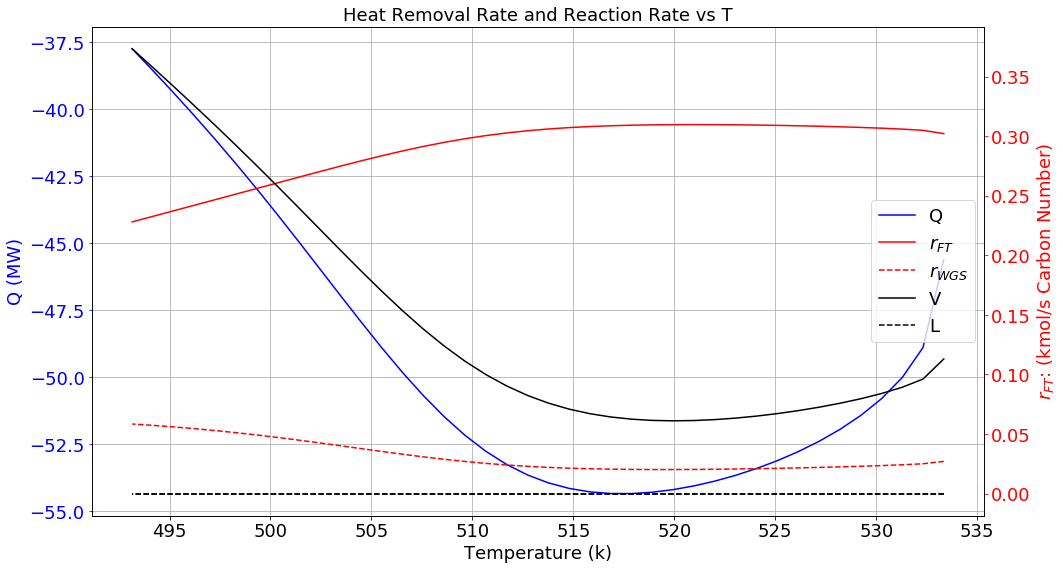

In [32]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
line6 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

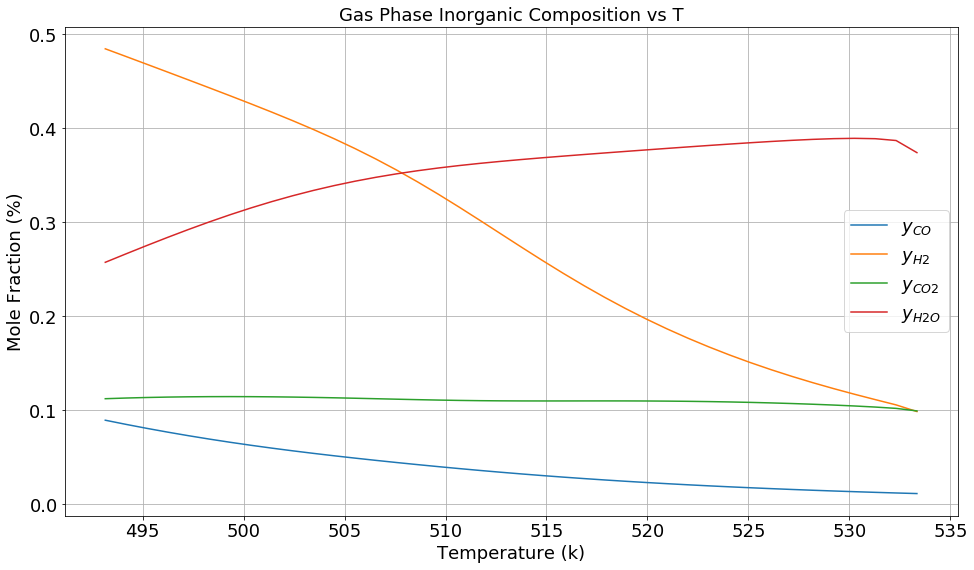

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

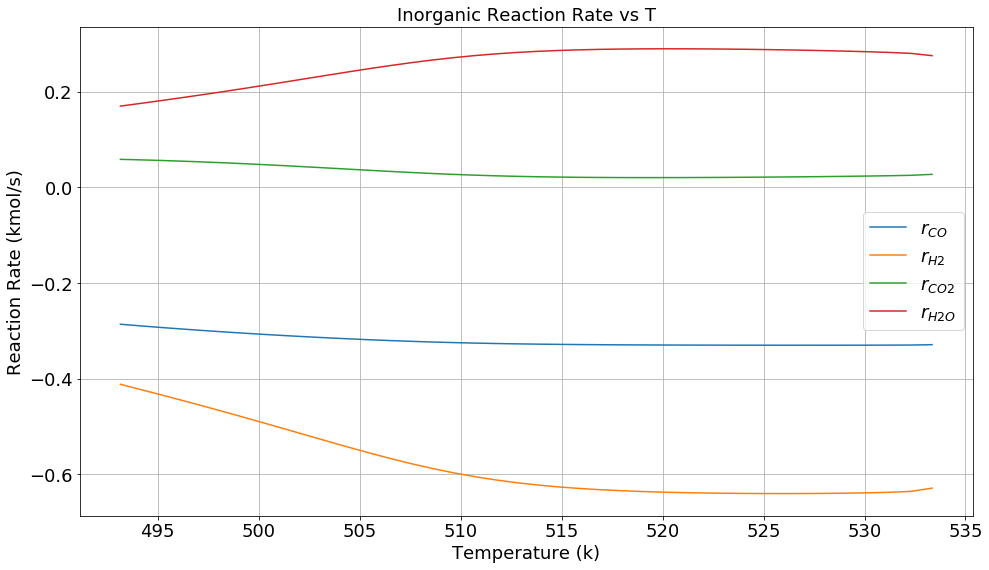

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

In [35]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

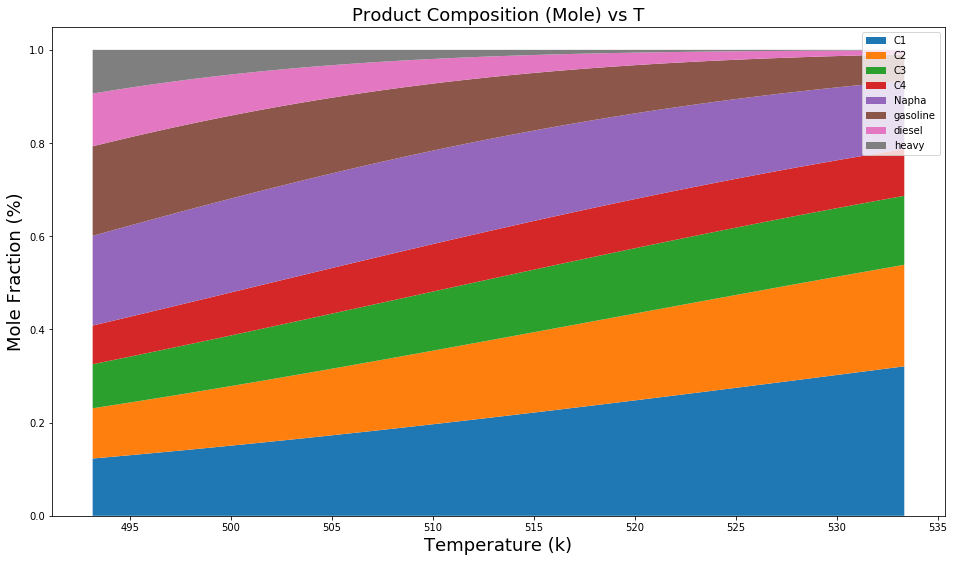

In [36]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

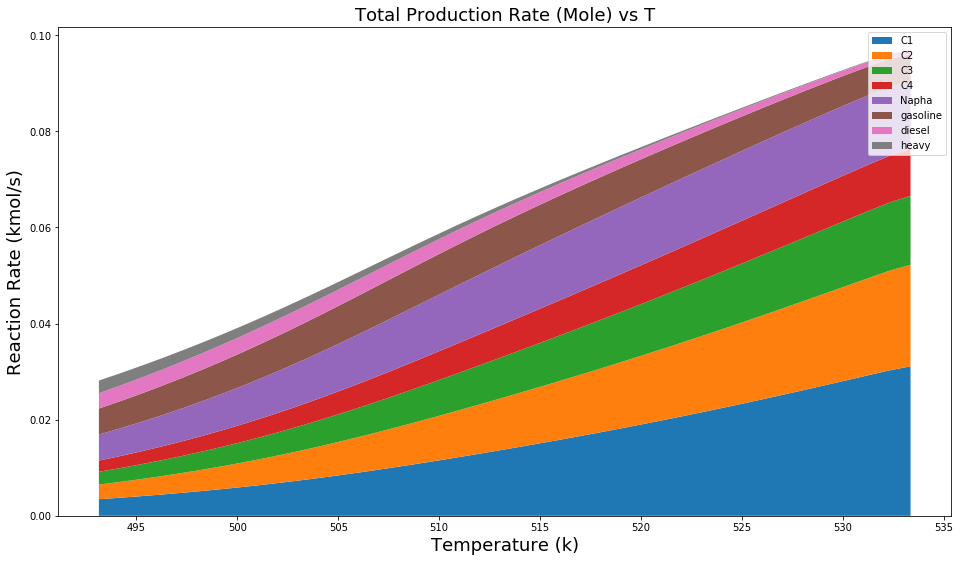

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [38]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

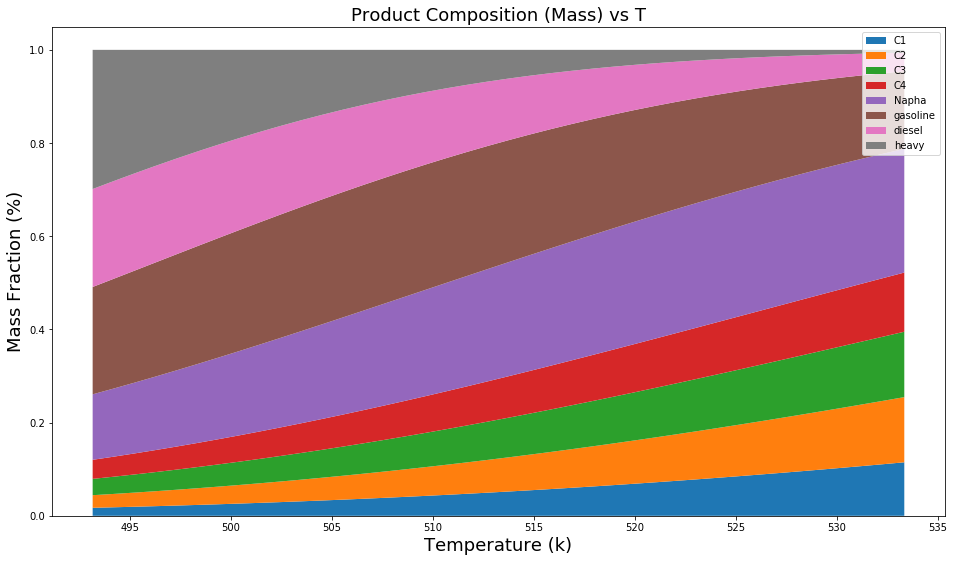

In [39]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

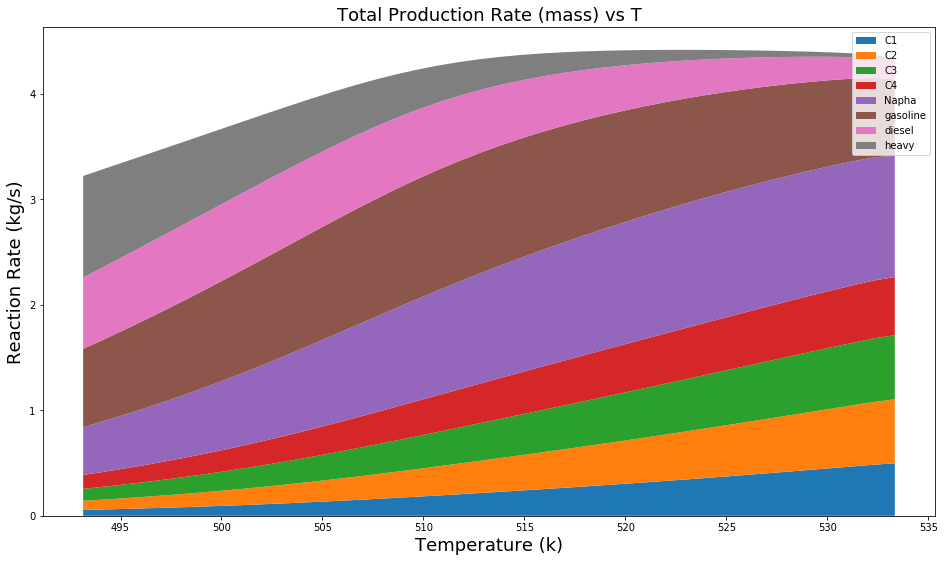

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [42]:
model.reactive[1].V.pprint()

V : Size=3, Index=reactive[1].stream
    Key : Lower : Value              : Upper : Fixed : Stale : Domain
      P :     0 :                  0 :  None :  True :  True : NonNegativeReals
     in :     0 :                  0 :  None :  True :  True : NonNegativeReals
    out :     0 : 0.5220444972044336 :  None : False : False : NonNegativeReals
